<a href="https://colab.research.google.com/github/nicolamassari/FinalPaper/blob/main/FinalPaper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Preparation

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import regex as re 
import matplotlib.pyplot as plt

pd.set_option('max_rows', 500)
pd.set_option('max_columns', 50)


df = pd.read_excel(r"/content/export_983270_927868.xls").drop('Origine', axis=1)

todrop = []
for var in ['Richieste', 'documento fiscale', 'Email', "Telefono", 'Check', 'Revenue', 
            'Agenzia', 'Note', 'Sposta', 'Piano', 'documento', 'Citt', 'Orario', 'tasse']:
  todrop.extend(list(df.columns[df.columns.str.startswith(var)]))
  todrop.extend(list(df.columns[df.columns.str.endswith(var)]))

df.drop(todrop, axis=1, inplace=True)
# print('\nRemoving', len(todrop), 'variables:', todrop)

df = df.dropna(how='any', axis=0)


# first exploratory analysis
print('The df has {} rows and {} columns.'.format(len(df), df.shape[1]))

print('\nThe number of null values is:', df.isnull().sum().sum(),' .')

if df.isnull().sum().sum() != 0:
  print('\nSummary of null values by column:\n', df.isnull().sum())

print('\nThe columns are:', list(df)[:12])
print('                ', list(df)[12:])



df0 = df.copy()

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


The df has 3992 rows and 22 columns.

The number of null values is: 0  .

The columns are: ['Data creazione', 'Data arrivo', 'Data partenza', 'Nome cliente', 'Codice', 'Origine della prenotazione', 'Pax', 'Notti', 'Camera', 'Stato', 'Totale', 'Prezzo netto commissioni']
                 ['Totale camera', 'Importo pagato', 'Tassa di soggiorno', 'Proprietà', 'Commissione OTA', 'Nazione', 'Lingua', 'Cleaning fee', 'PMS Real Planning', 'Totale da pagare']


In [ ]:
df = df0.copy()

# Weather df preparation

wdf = pd.read_excel(r"/content/weather_data2.xlsx")
wdf.interpolate(method='nearest', axis=0, limit_direction='both', inplace=True)

wdf['date_in'] = pd.to_datetime(wdf['DATA'], format='%d/%m/%Y')
wdf.drop(['Source.Name', 'DATA', 'LOCALITA', 'PUNTORUGIADA °C', 'UMIDITA %', 'VISIBILITA km', 'VENTOMEDIA km/h',
       'VENTOMAX km/h', 'RAFFICA km/h', 'PRESSIONESLM mb', 'PIOGGIA mm', 'PRESSIONEMEDIA mb'], axis=1, inplace=True)
wdf.FENOMENI.fillna('',inplace=True)
wdf['month'] = wdf.date_in.apply(lambda x: x.month)
for c in ['FENOMENI']:
    print("\nUnique values in variable " + str(c)+ ":\n", sorted(set(wdf[c].dropna())) + ([np.nan] if wdf[c].isnull().sum() > 0 else []))



wdf['rain'] = np.where(wdf.FENOMENI.str.contains('pioggia'), 1, 0)
wdf['fog'] = np.where(wdf.FENOMENI.str.contains('nebbia'), 1, 0)
# wdf['snow'] = np.where(wdf.FENOMENI.str.contains('neve'), 1, 0) #removed due to low informativity
wdf['storm'] = np.where(wdf.FENOMENI.str.contains('temporale'), 1, 0)
# wdf['prec'] = (wdf.rain + wdf.fog + wdf.snow + wdf.storm).astype(bool).astype('int64')
wdf.drop('FENOMENI', axis=1, inplace=True)

df0 = df.copy()


Unique values in variable FENOMENI:
 ['', 'nebbia ', 'neve nebbia ', 'pioggia ', 'pioggia nebbia ', 'pioggia temporale ', 'pioggia temporale nebbia ']


In [ ]:
df = df0.copy()

df.rename(columns=lambda x: re.sub(' ','_',x), inplace=True) # to ease later regression equations

df['date_in'] = pd.to_datetime(df['Data_arrivo'], format='%d/%m/%Y')
df['date_out'] = pd.to_datetime(df['Data_partenza'], format='%d/%m/%Y')
df['book_date'] = pd.to_datetime(df['Data_creazione'], format='%d/%m/%Y')

df = df.merge(wdf.drop(['month'], axis=1), on='date_in', how='left')

df['month_in'], df['day_in'], df['weekday_in'], df['week_in'], df['year_in'] = df.date_in.apply(lambda x: x.month), df.date_in.apply(lambda x: x.day), df.date_in.apply(lambda x: x.weekday()), df.date_in.apply(lambda x: x.week), df.date_in.apply(lambda x: x.year)
df['month_out'], df['day_out'], df['weekday_out'] = df.date_out.apply(lambda x: x.month), df.date_out.apply(lambda x: x.day), df.date_out.apply(lambda x: x.weekday())
df['weekend_stay'] = 0
df.loc[( ((df.weekday_in >= 4) & (df.weekday_in != 6)) | ( df.weekday_out>=5) | ((df.weekday_out < df.weekday_in) & (df.weekday_in != 6)) | (df.Notti >= 6) ), 'weekend_stay'] = 1
# df['weekday_book'] = df.book_date.apply(lambda x: x.weekday()) #removed due to low informativity
df['lead_time'] = (df.date_in - df.book_date).dt.days.astype('float64')
df.loc[df['lead_time'] < 0, 'lead_time'] = 0
df.loc[df['lead_time'] > 130, 'lead_time'] = 130

df['price_per_night'] = df['Totale'] / df['Notti']


df.drop(['weekday_out', 'Totale', 'Data_arrivo', 'Data_partenza', 'Data_creazione', 'Nome_cliente', 'Codice', 'Stato', 'Prezzo_netto_commissioni', 'Totale_camera',
       'Importo_pagato', 'Tassa_di_soggiorno', 'Proprietà', 'Commissione_OTA',
       'Cleaning_fee', 'PMS_Real_Planning', 'Totale_da_pagare', 'Nazione'], axis=1, inplace=True)

df.drop(df[df.price_per_night < 40].index, inplace=True)
df.rename(columns = {'Origine_della_prenotazione':'source', 'Notti':'nights', 'Camera':'room', 'Lingua':'language', 'TMEDIA °C':'avg_T', 
                     'TMIN °C':'min_T', 'TMAX °C':'max_T', 'Pax':'num_ppl'}, inplace = True)
df.drop(['avg_T','min_T'], axis=1, inplace=True)

df.source = df.source.apply(lambda x : re.sub(' ', '_', x))
df.loc[df.source.str.contains('octo')| df.source.str.contains('Octo'), "source"] = 'octo'

#combining same rooms with different names into unique categories
df.loc[df.room.str.contains('Erbe') | df.room.str.contains('ERBE'), "room"] = 'erbe'
df.loc[df.room.str.contains('ADUA') | df.room.str.contains('Adua'), "room"] = 'adua'
df.loc[df.room.str.contains('Leoni') | df.room.str.contains('LEONI'), "room"] = 'leoni'
df.loc[df.room.str.contains('Segreto'), "room"] = 'segreto'
df.loc[df.room.str.contains('Stella'), "room"] = 'stella'
df.loc[df.room.str.contains('Barbarani'), "room"] = 'barbarani'
df.loc[df.room.str.contains('Choco'), "room"] = 'choco'
df.loc[df.room.str.contains('Silver'), "room"] = 'silver'
df.loc[df.room.str.contains('Simoni'), "room"] = 'simoni'
df.loc[df.room.str.contains('Cat'), "room"] = 'caterina'
df.loc[df.room.str.contains('Gold'), "room"] = 'gold'
df.loc[df.room.str.contains('Gialla'), "room"] = 'yellow'
df.loc[df.room.str.contains('King'), "room"] = 'king'
df.loc[df.room.str.contains('Blu&Green') | df.room.str.contains('Verde'), "room"] = 'bluegreen'
df.loc[df.room.str.contains('Verde'), "room"] = 'green'
df.loc[df.room.str.contains('White'), "room"] = 'white'
df.loc[df.room.str.contains('Torre'), "room"] = 'torre'
df.loc[df.room.str.contains('Fama'), "room"] = 'fama'
df.loc[df.room.str.contains('Queen'), "room"] = 'queen'
df.loc[df.room.str.contains('Spring'), "room"] = 'spring'
df.loc[df.room.str.contains('Summer') | df.room.str.contains('Rossa'), "room"] = 'summer'
df.loc[df.room.str.contains('Rossa'), "room"] = 'rossa'
df.loc[df.room.str.contains('Zeno'), "room"] = 'zeno'
df.loc[df.room.str.contains('Mansarda'), "room"] = 'mansarda'
df.loc[df.room.str.contains('Monolocale'), "room"] = 'monolocale'
df.loc[df.room.str.contains('Studio'), "room"] = 'studio'


#create interaction variables between weather data and lead time

for i in ['max_T', 'rain', 'fog', 'storm']:
  df[i+'x'+'lead_time'] = df[i].astype('float64') / (1+df.lead_time.astype('float64'))



df0 = df.copy()


In [ ]:
df = df0.copy()
df['demand'] = np.nan
df['occupancy'] = np.nan
df['meanMA'] = np.mean(df.price_per_night)

pd.set_option('mode.chained_assignment', None)

for i in range(len(df)):
  df2= df.copy()
  ran = pd.date_range(df2["book_date"].iloc[i]-pd.Timedelta(days=6), df2["book_date"].iloc[i]-pd.Timedelta(days=1))
  din, dout = df2["date_in"].iloc[i], df2["date_out"].iloc[i]
  df2['check'] = df2.book_date.isin(ran)
  df2 = df2[df2.check==1]
  df['demand'].iloc[i] = len(df2[(df2.date_in<dout) & (df2.date_out>din)])
  df['meanMA'].iloc[i] =  np.mean(df2.price_per_night[df2.date_in == din])

  df2 = df.copy()
  din, dout, dbook = df2["date_in"].iloc[i], df2["date_out"].iloc[i], df2.book_date.iloc[i]
  ran = pd.date_range(din, dout)
  occ = list()
  prev_occ = list()
  for d in ran:
    d = d.strftime("%Y-%m-%d")
    occ = occ + [((df2[(d>=df2.date_in) & (d<df2.date_out)]).book_date<=dbook).sum()]
    prev_occ = prev_occ + [((df2[(d>=df2.date_in) & (d<df2.date_out)]).book_date<=dbook-pd.Timedelta(days=7)).sum()]

  df['occupancy'].iloc[i] = max(occ)/26
  # df['occupancy_lag'].iloc[i] = max(prev_occ)/26

df['occupancyxlead_time'] = df.occupancy * df.lead_time
df['demandxlead_time'] = df.demand * df.lead_time

df.drop(['book_date', 'date_in', 'date_out', 'month_out', 'day_out'], axis=1, inplace=True)


# df2=df.copy()
# din, dout, dbook = df2["date_in"].iloc[i], df2["date_out"].iloc[i], df2.book_date.iloc[i]
# df['occupancy'].iloc[i] = ((df2[(df2.date_in<dout) & (df2.date_out>din)]).book_date < dbook).sum()/26
  
df0 = df.copy()

In [ ]:
df.to_csv('dataset_room_pricing_full.csv', index=False)

df.columns

Index(['source', 'num_ppl', 'nights', 'room', 'language', 'max_T', 'rain',
       'fog', 'storm', 'month_in', 'day_in', 'weekday_in', 'week_in',
       'year_in', 'weekend_stay', 'lead_time', 'price_per_night',
       'max_Txlead_time', 'rainxlead_time', 'fogxlead_time', 'stormxlead_time',
       'demand', 'occupancy', 'meanMA', 'occupancyxlead_time',
       'demandxlead_time'],
      dtype='object')

##Visualization

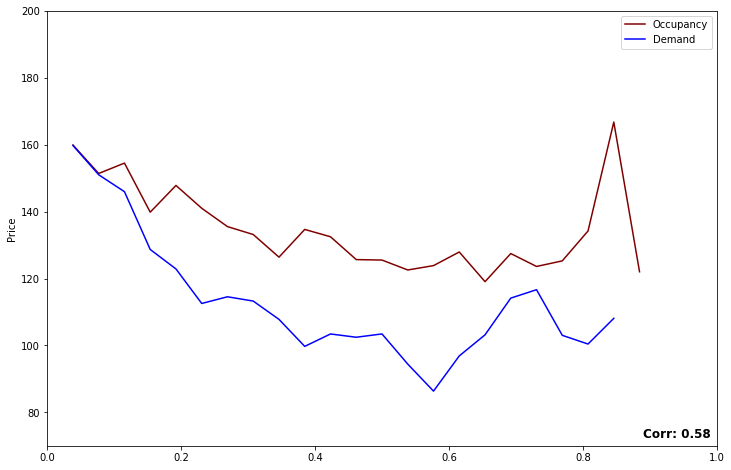

In [ ]:
df = df0.copy()
# df.groupby('month_in')['price_per_night'].mean().plot.bar(color='darkcyan', alpha=0.5, figsize=(12, 8), ylim=(70,160), label='Price per night')
# df.groupby('month_in')['avg_T'].mean().plot.bar(color='mediumseagreen', alpha=0.5, figsize=(12, 8), ylim=(0,40), label='Average temperature')

#-----------------------------------------

# fig, ax1 = plt.subplots()
# wdf.month = wdf.month-1

# ax1.set_ylabel('Price')
# df.groupby('month_in')['price_per_night'].mean().plot.bar(color='teal', alpha=0.7, figsize=(12, 8), ylim=(70,160), label='Price per night')
# ax1.tick_params(axis="x", rotation=0)
# ax1.set_xlabel('Month')
# ax2 = ax1.twinx()

# ax2.set_ylabel('T', rotation=270)
# wdf.groupby('month')['TMAX °C'].mean().plot(color='maroon', alpha=0.8, figsize=(12, 8), ylim=(0,35), label='Average temperature')
# ax1.legend(['ADR'], loc='upper left')
# ax2.legend(['Average temperature'])
# fig.tight_layout()  # otherwise the right y-label is slightly clipped


#---------------
# (df.nights.value_counts()/3992)[:7].plot.bar(color='goldenrod',figsize=(12, 8),ylim=(0,1))
# plt.xlabel('nights')
# plt.legend(['Frequency'])
#------------------------------
# fig, ax = plt.subplots()

# df.groupby('lead_time')['price_per_night'].mean().plot.line(color='goldenrod', alpha=0.7, figsize=(12, 8), ylim=(70,300), xlim=(0,200), label='Price per night')
# df.groupby('lead_time')['price_per_night'].mean().rolling(window=7, center=True).mean().plot.line(color='teal', alpha=1, figsize=(12, 8), ylim=(70,300), xlim=(0,200), label='Price per night')
# plt.legend(['ADR', '7 Days Centered MA'])
# ax.set_ylabel('Price')
# ax.set_xlabel('Lead Time')

#
fig, ax = plt.subplots()

df.groupby('occupancy')['price_per_night'].mean().plot.line(color='maroon', alpha=1, figsize=(12, 8), ylim=(70,200), xlim=(0,1), label='Price per night')
df.demand = df.demand/26
df.groupby('demand')['price_per_night'].mean().plot.line(color='blue', alpha=1, figsize=(12, 8), ylim=(70,200), xlim=(0,1), label='Price per night')
plt.legend(['Occupancy', 'Demand'])
ax.set_ylabel('Price')
ax.set_xlabel('')
plt.text(0.89, 72.5, "Corr: 0.58", fontdict={'family': 'cursive',
        'color':  'k',
        'weight': 'bold',
        'size': 12})


plt.show()

In [ ]:
# df = df0.copy()
# df = df[['price_per_night', 'demand', 'occupancy', 'lead_time', 'num_ppl', 'nights', 'min_T', 'max_T', 'min_Txlead_time', 'max_Txlead_time', 'rainxlead_time', 'fogxlead_time', 'stormxlead_time']]
# f = plt.figure(figsize=(12, 8))
# plt.matshow(df.corr(), fignum=f.number)
# plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
# plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)

# plt.show()

# df.corr()


##Outliers

In [ ]:
df = df0.copy()
num_cols = list(df.select_dtypes(np.float64).columns)
num_cols.remove('nights')
num_cols.remove('lead_time')
m = 2 # set IQR multiplier
for i in num_cols:
  Q1 = df[i].quantile(0.25)
  Q3 = df[i].quantile(0.75)
  IQR = Q3 - Q1    # interquartile range. 
  filter_min = (df[i] < Q1 - m * IQR) # substitute values that are larger than 1.5 times the IQR with the closest acceptable value
  filter_max = (df[i] > Q3 + m *IQR)
  df.loc[filter_min, i] =  Q1 - m * IQR
  df.loc[filter_max, i] =  Q3 + m * IQR

  print('Filtered ', filter_min.sum() + filter_max.sum(), ' values for', i, ', min accepted value:', np.round(Q1 - m * IQR, 1), ', max accepted value:', np.round(Q3 + m * IQR, 1))




##Variable Transformation

In [ ]:
df = df0.copy()
num_cols = list(df.select_dtypes(np.float64).columns)
num_cols.remove('price_per_night')
num_cols = ['num_ppl', 'nights', 'lead_time', 'demand', 'occupancy']
thr = .85
for i in num_cols:
    if sum(df[i] <= 0) == 0: # can use all transformations
        df[i + '_sqar'] = df[i] ** 2
        df[i + '_sqrt'] = np.sqrt(df[i])
        df[i + '_cube'] = df[i] ** 3
        df[i + '_cbrt'] = np.cbrt(df[i])
        df[i + '_rec'] = 1/df[i]

        # drop transformed variables that are too correlated with the original one
        todrop = np.array([i + '_sqar', i + '_sqrt', i + '_cube', i + '_cbrt', i + '_rec'])[np.corrcoef(df[i], [df[i + '_sqar'], df[i + '_sqrt'], df[i + '_cube'], df[i + '_cbrt'], df[i + '_rec']])[0,1:]>thr]
        print('Dropped Transformations for ', i, ':\n\t', todrop)
        df.drop(todrop, axis=1, inplace=True)
    
    elif sum(df[i] < 0) == 0: # skip reciprocal
        df[i + '_sqar'] = df[i] ** 2
        df[i + '_sqrt'] = np.sqrt(df[i])
        df[i + '_cube'] = df[i] ** 3
        df[i + '_cbrt'] = np.cbrt(df[i])

        # drop transformed variables that are too correlated with the original one
        todrop = np.array([i + '_sqar', i + '_sqrt', i + '_cube', i + '_cbrt'])[np.corrcoef(df[i], [df[i + '_sqar'], df[i + '_sqrt'], df[i + '_cube'], df[i + '_cbrt']])[0,1:]>thr]
        print('Dropped Transformations for ', i, ':\n\t', todrop)
        df.drop(todrop, axis=1, inplace=True)
    
    else: #skip sqrt
        df[i + '_sqar'] = df[i] ** 2
        df[i + '_cube'] = df[i] ** 3
        df[i + '_cbrt'] = np.cbrt(df[i])

        # drop transformed variables that are too correlated with the original one
        todrop = np.array([i + '_sqar', i + '_cube', i + '_cbrt'])[np.corrcoef(df[i], [df[i + '_sqar'], df[i + '_cube'], df[i + '_cbrt']])[0,1:]>thr]
        print('Dropped Transformations for ', i, ':\n\t', todrop)
        df.drop(todrop, axis=1, inplace=True)

# new = [str(i) for i in df.columns if (str(i) not in num_cols and str(i) not in cat_cols)]
# print('\nNew transformations: ', new )

num_cols = list(df.columns[df.dtypes==np.float64])

print("\nThe dataset now has {} rows and {} columns".format(df.shape[0], df.shape[1]) )

df0 = df.copy()

Dropped Transformations for  num_ppl :
	 ['num_ppl_sqar' 'num_ppl_sqrt' 'num_ppl_cube' 'num_ppl_cbrt']
Dropped Transformations for  nights :
	 ['nights_sqrt' 'nights_cbrt']
Dropped Transformations for  lead_time :
	 ['lead_time_sqar' 'lead_time_sqrt' 'lead_time_cbrt']
Dropped Transformations for  demand :
	 ['demand_sqar' 'demand_sqrt' 'demand_cbrt']
Dropped Transformations for  occupancy :
	 ['occupancy_sqar' 'occupancy_sqrt' 'occupancy_cube' 'occupancy_cbrt']

The dataset now has 3968 rows and 32 columns


##Multicollinearity checks (pairwise)

In [ ]:
df = df0.copy()
y = 'price_per_night'
df1 = df.select_dtypes(np.float64) #filter only numerical variables

#creating a dataframe for correlation (x, y) in ascending order
corr = pd.DataFrame()
for x in list(df1)[1:]:
    corr.loc[x, y] = df1[x].corr(df1[y])
corr = corr.loc[abs(corr).sort_values([y]).index, :]

print('Correlation (x, y)')
print(corr)

#only looking at pairwise collinearity between two x variables 
#dropping any variable x that is highly correlated with another x
#if 2 x variables are similarly correlated with variable y, we assume they are closely correlated with each other

delta = 0.05 #our limit for the difference
dl2 = [] #list of variables to be deleted
while True:
    a = abs(corr).diff() <= delta #variables that have similar correlation (x, y)
    colname = list(df1)[1:]
    dl = [] #temporary list of variables to be deleted
    print('\nX pairs with correlations >', 1 - delta, ":")
    for b in range(1, a.shape[0]):
        if a.iloc[b, 0]:
            if abs(df1[a.index[b - 1]].corr(df1[a.index[b]])) > (1 - delta):
                #deleting a variable from the pair that have similar correlation (x, y)
                dv0 = a.index[b - 1]
                dv1 = a.index[b]
                
                #deleting the variable with the lower correlation (x, y) from the pair that have similar correlation (x, y) 
                if not (dv0 in dl) and not (dv1 in dl):
                    if abs(corr.loc[dv0, y]) >= abs(corr.loc[dv1, y]):
                        d = dv1 
                    else:
                        d = dv0
                    dl.append(d)
                    corr.drop([d], axis = 0, inplace = True)
                    
                    print(dv0, ',', dv1)
                    
    #output listing the variables that were deleted                
    if len(dl) > 0:
        df.drop(axis = 1, columns = dl, inplace = True)
        dl2 = dl2 + dl
        print('\n' + str(len(dl)), 'variables considered for deletion')
        print('\n'.join([str(x) for x in dl]))
    else:
        print('No collinear variables found.')
        break
        
print('\n' + str(len(dl2)), 'collinear variables deleted.') 

print("\nThe dataset now has {} rows and {} columns".format(df.shape[0], df.shape[1]) )

df0 = df.copy()

Correlation (x, y)
                     price_per_night
nights_cube                -0.024410
nights_sqar                -0.034129
nights                     -0.060712
nights_rec                  0.073224
stormxlead_time            -0.103984
fogxlead_time              -0.117479
rainxlead_time             -0.146307
demand_cube                -0.151461
occupancy_rec               0.166834
occupancy                  -0.180737
demandxlead_time            0.224075
max_T                       0.265123
lead_time_cube              0.293254
max_Txlead_time            -0.298045
demand                     -0.309276
occupancyxlead_time         0.421795
lead_time                   0.469017
meanMA                      0.624183
price_per_night             1.000000

X pairs with correlations > 0.95 :
nights_cube , nights_sqar

1 variables considered for deletion
nights_cube

X pairs with correlations > 0.95 :
No collinear variables found.

1 collinear variables deleted.

The dataset now has 3968 rows a

##Categorical Dummies


In [ ]:
df = df0.copy()
# df.to_csv('dataset_room_pricing_full.csv', index=False)

cat_cols = ['source', 'room',
       'language', 'day_in', 'month_in', 'weekday_in', 'week_in', 'year_in']
for c in cat_cols:
  df[c] = df[c].astype(str)
  df[c] = df[c].apply(lambda x: re.sub(' ','_',x))
  print("\nUnique values in variable " + str(c)+ ":\n", sorted(set(df[c].dropna())) + ([np.nan] if df[c].isnull().sum() > 0 else []))


# create dummies
dum = pd.get_dummies(df[cat_cols], drop_first=True)
df = pd.concat([df.drop(cat_cols, axis=1), dum], axis=1)

thr = len(df)/200
sp_list = list(dict(np.any((df.loc[:, df.nunique()==2].apply(lambda x: x.value_counts()))< thr ,axis=0)).items()) # check for columns that cause sparsity to drop them
todrop = []

for i in range(len(sp_list)):
  if sp_list[i][1] == True:
    todrop.append(sp_list[i][0])

df.drop(todrop, axis=1, inplace=True)
print("\n\n"+str(todrop)+' dropped because of minority group with frequency lower than ', thr/len(df))

cat_cols = list(df.columns[df.dtypes==np.uint8])

df.rename(columns=lambda x: re.sub('\W', '_', x), inplace=True) #replace all ' ' with '_'

print("\nThe dataset now has {} rows and {} columns".format(df.shape[0], df.shape[1]) )

df0 = df.copy()


Unique values in variable source:
 ['airbnb_xml', 'booking_xml', 'expedia', 'octo']

Unique values in variable room:
 ['adua', 'barbarani', 'bluegreen', 'caterina', 'choco', 'erbe', 'fama', 'gold', 'king', 'leoni', 'mansarda', 'monolocale', 'queen', 'segreto', 'silver', 'simoni', 'spring', 'stella', 'studio', 'summer', 'torre', 'white', 'yellow', 'zeno']

Unique values in variable language:
 ['ca', 'de', 'el', 'en', 'es', 'fr', 'it', 'ja', 'nl', 'pt', 'ro', 'ru', 'tr', 'zh']

Unique values in variable day_in:
 ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '4', '5', '6', '7', '8', '9']

Unique values in variable month_in:
 ['1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9']

Unique values in variable weekday_in:
 ['0', '1', '2', '3', '4', '5', '6']

Unique values in variable week_in:
 ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '

In [ ]:
df.to_csv('dataset_room_pricing.csv', index=False)


#Model 1: OLS

In [ ]:
from sklearn.feature_selection import SelectPercentile as SP
from sklearn.feature_selection import mutual_info_regression as MI
df = df0.copy()


y = 'price_per_night' # set y to be the name of target column

y_col = df.pop(y)

if False: #mutual information variable selection
  selector = SP(score_func=MI, percentile=70) # select features with top 50% MI scores
  selector.fit(df,y_col)

  df = df[list(selector.get_feature_names_out(list(df.columns)))]


todrop = []
if len(list(df.columns[df.nunique()==1]))>0:
  todrop = list(df.columns[df.nunique()==1]) #drop constant columns (if any)
  print('The following columns are constant:', todrop)
else:
  print('No constant columns to drop')

for var in [y, 'out']:
  todrop.extend(list(df.columns[df.columns.str.startswith(var)]))
  todrop.extend(list(df.columns[df.columns.str.endswith(var)]))
  todrop.extend(list(df.columns[df.columns.str.contains(var)]))

df.drop(todrop, axis=1, inplace=True)
print('\nRemoving', len(todrop), 'variables:', todrop)

df.insert(0, y, y_col) # move target column in first position
del y_col

No constant columns to drop

Removing 0 variables: []


##Multicollinearity checks (pairwise)

In [ ]:
df1 = df.select_dtypes(np.float64) #filter only numerical variables

#creating a dataframe for correlation (x, y) in ascending order
corr = pd.DataFrame()
for x in list(df1)[1:]:
    corr.loc[x, y] = df1[x].corr(df1[y])
corr = corr.loc[abs(corr).sort_values([y]).index, :]

print('Correlation (x, y)')
print(corr)

#only looking at pairwise collinearity between two x variables 
#dropping any variable x that is highly correlated with another x
#if 2 x variables are similarly correlated with variable y, we assume they are closely correlated with each other

delta = 0.05 #our limit for the difference
dl2 = [] #list of variables to be deleted
while True:
    a = abs(corr).diff() <= delta #variables that have similar correlation (x, y)
    colname = list(df1)[1:]
    dl = [] #temporary list of variables to be deleted
    print('\nX pairs with correlations >', 1 - delta, ":")
    for b in range(1, a.shape[0]):
        if a.iloc[b, 0]:
            if abs(df1[a.index[b - 1]].corr(df1[a.index[b]])) > (1 - delta):
                #deleting a variable from the pair that have similar correlation (x, y)
                dv0 = a.index[b - 1]
                dv1 = a.index[b]
                
                #deleting the variable with the lower correlation (x, y) from the pair that have similar correlation (x, y) 
                if not (dv0 in dl) and not (dv1 in dl):
                    if abs(corr.loc[dv0, y]) >= abs(corr.loc[dv1, y]):
                        d = dv1 
                    else:
                        d = dv0
                    dl.append(d)
                    corr.drop([d], axis = 0, inplace = True)
                    
                    print(dv0, ',', dv1)
                    
    #output listing the variables that were deleted                
    if len(dl) > 0:
        df.drop(axis = 1, columns = dl, inplace = True)
        dl2 = dl2 + dl
        print('\n' + str(len(dl)), 'variables considered for deletion')
        print('\n'.join([str(x) for x in dl]))
    else:
        print('No collinear variables found.')
        break
        
print('\n' + str(len(dl2)), 'collinear variables deleted.') 

print("\nThe dataset now has {} rows and {} columns".format(df.shape[0], df.shape[1]) )

Correlation (x, y)
                     price_per_night
nights_sqar                -0.034129
nights                     -0.060712
nights_rec                  0.073224
stormxlead_time            -0.103984
fogxlead_time              -0.117479
rainxlead_time             -0.146307
demand_cube                -0.151461
occupancy_rec               0.166834
occupancy                  -0.180737
demandxlead_time            0.224075
max_T                       0.265123
lead_time_cube              0.293254
max_Txlead_time            -0.298045
demand                     -0.309276
occupancyxlead_time         0.421795
lead_time                   0.469017
meanMA                      0.624183
num_ppl                     0.646562

X pairs with correlations > 0.95 :
No collinear variables found.

0 collinear variables deleted.

The dataset now has 3968 rows and 153 columns


##Variable Selection


In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

descr = True # turn on/off descriptions for each step of selection

cn = list(df) # the columns are already ordered with target in first position, so no need to reorder them

modeleq = ' + '.join(cn).replace('+', '~', 1)
    
bmodeleq = modeleq # best model so far
print('Starting Model with ', len(list(df))-1,' features + intercept:\n' + bmodeleq)

print('\nVariable Selection using t-stat p-value & PR(>F):')

minfpv = np.inf     # set to infinity, minimum PR(>F) so far
minaic = np.inf  # set to -infinity, min AIC so far


# TRAIN TEST SPLIT

from sklearn.model_selection import train_test_split

p = 0.3
random_sample = True
if random_sample:
  x_train, x_test, y_train, y_test = train_test_split( df.drop([y],axis=1) , df[y] , test_size=p , random_state=1)
else:
  x_train, x_test, y_train, y_test = df.drop([y],axis=1)[:int((1-p)*len(df))], df.drop([y],axis=1)[int((1-p)*len(df)):], df[y][:int((1-p)*len(df))], df[y][int((1-p)*len(df)):]
    
trn = pd.concat([y_train, x_train], axis=1)
tst = pd.concat([y_test, x_test], axis=1)


# start selection loop
while True:
    dfout = ols(modeleq, trn).fit()

    fpv = dfout.f_pvalue # current PR(>F)

    #see if a better model (smaller PR(>F)) is found, while keeping also the condition that all Xs are significant with p-values smaller or equal to 0.07
    # [we need to include the t-stat p-values check as the f-value refers to model significance, with H0: all Xs are equal to 0, H1: at least one X is different from 0,
    # therefore to test for each individual X's significance we need to use p-values from the t-statistic]
    if fpv < minfpv and sum(dfout.pvalues > .05) == 0:
        minfpv = fpv
        minaic = dfout.aic
        bmodeleq = modeleq
    elif fpv == 0.0:    # if PR(>F) is already .0 we solve with aic
        if dfout.aic <= minaic and sum(dfout.pvalues > .05) == 0:
            minfpv = fpv
            minaic = dfout.aic
            bmodeleq = modeleq
        
    numx = modeleq.count(' + ') + 1 #(number of Xs)
    if descr:
      print('\nF-statistic =', dfout.fvalue, '       PR(>F) =', fpv, 'for', numx, 'Xs, of which ', sum(dfout.pvalues > .05), ' are non significant, AIC=', dfout.aic )

    if modeleq.find(' + ') == -1: # means that only one X is left, can't drop anymore
        break # exit loop

    #identify X variable to drop by finding the one with largest ANOVA p-value:
    
    prf = sm.stats.anova_lm(dfout, typ=2).iloc[:-1, :].sort_values(['F']
                        ).sort_values(['df'], ascending=False)['PR(>F)']
    maxp = max(prf)
    xdrop = prf[maxp == prf].axes[0][0]  # element with largest PR(>F) in ANOVA

    # removing xdrop
    if (modeleq.find('~ ' + xdrop + ' + ') != -1): # xdrop is 1st x
        modeleq = modeleq.replace('~ ' + xdrop + ' + ', '~ ')
    elif (modeleq.find('+ ' + xdrop + ' + ') != -1):
        modeleq = modeleq.replace('+ ' + xdrop + ' + ', '+ ')
    else: #xdrop is last x
        modeleq = modeleq[:-len(xdrop) - 3]

    if descr:
      print('Variable to drop:', xdrop, '       p-value =', prf[xdrop])

# end selection loop

print('\nBest model equation:', bmodeleq)
print('\nMinimum PR(>F) =', minfpv, 'for', bmodeleq.count(' + ') + 1, 'Xs.\nBest AIC = ', minaic)

o = ols(bmodeleq, trn).fit()

i = o.params.index

xs = pd.concat([pd.Series(i, index=i), o.params, o.tvalues, o.pvalues], axis=1
              ).sort_values(2, key=abs, ascending=False)
xs.columns = ['', 'Coefficient', 't-stat', 'P>|t|']
xs.index = range(1, len(xs) + 1)
print('\n\nWorse 10 p-values: \n', xs[-10:].sort_values(['P>|t|'], ascending=False))



Starting Model with  152  features + intercept:
price_per_night ~ num_ppl + nights + max_T + rain + fog + storm + weekend_stay + lead_time + max_Txlead_time + rainxlead_time + fogxlead_time + stormxlead_time + demand + occupancy + meanMA + occupancyxlead_time + demandxlead_time + nights_sqar + nights_rec + lead_time_cube + demand_cube + occupancy_rec + source_booking_xml + source_octo + room_barbarani + room_bluegreen + room_caterina + room_choco + room_erbe + room_fama + room_gold + room_king + room_leoni + room_mansarda + room_monolocale + room_queen + room_segreto + room_silver + room_spring + room_stella + room_studio + room_summer + room_torre + room_white + room_yellow + room_zeno + language_de + language_en + language_es + language_fr + language_it + language_nl + language_pt + language_ro + language_ru + day_in_10 + day_in_11 + day_in_12 + day_in_13 + day_in_14 + day_in_15 + day_in_16 + day_in_17 + day_in_18 + day_in_19 + day_in_2 + day_in_20 + day_in_21 + day_in_22 + day_in_23

##Results

In [ ]:
# -------------[Pre-Processing/Partitioning]-------------------
df = df0.copy()


if 0: # standardization yes/no
    from sklearn.preprocessing import StandardScaler

    std_scaler = StandardScaler()

    trn ,tst = pd.DataFrame(std_scaler.fit_transform(trn), columns=trn.columns), pd.DataFrame(std_scaler.transform(tst), columns=tst.columns)# [Fit scale to train features + scale train and test] 

    y_train, x_train, y_test, x_test = trn[y], trn.drop([y], axis=1), tst[y], tst.drop([y], axis=1)



# -------------[Regression]-------------------

print('\nModel equation:', bmodeleq, '\n')


model = ols(bmodeleq, trn)
results = model.fit() # regression output

print('Train Set Results:\n         Mean Absolute Error =', abs(y_train - results.fittedvalues).mean())
print('     Root Mean Squared Error =', ((y_train - results.fittedvalues) ** 2.).mean() ** 0.5)
# Results on Training Data
print('\n\nModel Summary:\n', results.summary2())

# Predict test ys
y_pred = results.predict( x_test )

print('\nTest Set Results:\n         Mean Absolute Error =', abs(y_test - y_pred).mean())
print('     Root Mean Squared Error =', ((y_test - y_pred) ** 2.).mean() ** 0.5)
r = y_test.corr(y_pred) ** 2.
n = len(tst)
k = bmodeleq.count(' + ') + 1
adjr = 1 - ((1-r)*(n-1)/(n-k-1)) # computing adjusted R2 
print('                          R² = '+ str(r) + '\n                       adjR² = ' + str(adjr))


Model equation: price_per_night ~ num_ppl + weekend_stay + demand + meanMA + demandxlead_time + lead_time_cube + demand_cube + room_bluegreen + room_caterina + room_choco + room_king + room_leoni + room_stella + room_white + month_in_11 + month_in_12 + month_in_4 + month_in_5 + month_in_6 + month_in_7 + weekday_in_5 + week_in_31 + week_in_32 + week_in_33 + week_in_34 + week_in_35 + week_in_36 + week_in_37 + week_in_38 + week_in_39 + week_in_43 + year_in_2022 

Train Set Results:
         Mean Absolute Error = 17.599536051435784
     Root Mean Squared Error = 24.83327302291752


Model Summary:
                   Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.731     
Dependent Variable: price_per_night  AIC:                16645.4201
Date:               2022-10-26 16:58 BIC:                16826.5892
No. Observations:   1790             Log-Likelihood:     -8289.7   
Df Model:           32               F-statistic:        153.2     
Df Resid

In [ ]:
abs(results.tvalues).sort_values(ascending=False)

num_ppl             25.375478
meanMA              21.400601
month_in_7           8.744828
demandxlead_time     8.018557
demand               7.880617
month_in_4           6.936157
week_in_39           6.711921
room_white           6.459738
month_in_5           6.438078
week_in_34           6.307818
weekend_stay         6.298783
weekday_in_5         6.154053
week_in_33           6.143037
week_in_35           6.085386
room_stella          6.045514
week_in_32           6.041190
room_caterina        5.810461
week_in_36           5.713506
room_king            5.646361
month_in_6           5.575314
room_leoni           5.455546
room_bluegreen       5.068907
week_in_37           4.923595
demand_cube          4.714082
year_in_2022         4.628237
room_choco           4.581167
week_in_31           4.534797
month_in_12          4.455803
lead_time_cube       4.378417
week_in_38           4.047187
week_in_43           3.299861
month_in_11          3.129537
Intercept            2.504111
dtype: flo

In [ ]:
# df[['price_per_night'] + bmodeleq[18:].split(' + ')].to_csv('dataset_room_pricing.csv', index=False)

#OLD

In [ ]:
df = df0.copy()

index_col = df.Time #keep the timeindex col, then temporarily remove to allow df.interpolate to work

df.drop(['Time', 'Date', 'Date2'], axis=1, inplace=True) #we already have all of this info from the other columns

#______________[Null values analysis]______________
if True:
  df_null = pd.DataFrame(df[df.isnull().any(axis=1)], columns = df.columns)
  df_null.reset_index(inplace=True, drop=True)
  print('Null Values Description:\n\n',df_null.describe(),'\n\n           Value:    Count:\n', df_null[['season', 'yr', 'mnth', 'day', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']].apply(lambda x: x.value_counts()).T.stack())
  del df_null
#__________________________________________________

df.interpolate(method='linear', axis=0, limit_direction='both',inplace=True)
assert df.isnull().sum().sum()==0

df0 = df.copy()

In [ ]:
df = df0.copy()

df.weathersit = df.weathersit.astype(np.uint8) # because of interpolation some data points are not int

cat_cols = ['season', 'yr', 'mnth', 'day', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']
df[cat_cols] = df[cat_cols].astype(object) #make categorical columns object type


#Define lists of numerical and categorical values
num_cols = list(df.columns[df.dtypes!=object])
cat_cols = list(df.columns[df.dtypes==object])

def drop(df, todrop, reason='', detailed=False): #function to drop columns removing them from lists
  if type(todrop)== str:
    todrop = list(todrop)
  dropping = []
  for c in todrop:
    dropping.extend(list(df.columns[df.columns.str.startswith(c)]))
  df.drop(dropping, axis=1, inplace=True)
  for c in dropping:      #removing dropped columns from type list
    try:
      cat_cols.remove(c)
    except:
      try:
        num_cols.remove(c)
      except:
        if detailed:
          print("\nThe column " + str(c) + " wasn't in any of the lists")
    
  print('Dropped ' + str(dropping) + reason)

  return df

todrop = np.array(cat_cols)[df[cat_cols].nunique()/len(df) > 0.9] #drop categoricals with too many unique values (>90%)
df = drop(df, todrop)

df0 = df.copy()